In [1]:
import os
import sys 
import matplotlib.pyplot as plt
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import mlflow
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline


In [2]:
sys.path.append('../scripts')

In [3]:
# Load the data
train = pd.read_csv('../data/train.csv')
store = pd.read_csv('../data/store.csv')



C:\Users\amanu\AppData\Local\Temp\ipykernel_15880\1274324609.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv')


In [4]:
# Merge train and store data
df = pd.merge(train, store, on='Store', how='left')

In [5]:
# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                   

### Preprocessing 

In [6]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Extract features from the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek
df['Is_weekend'] = (df['Weekday'] >= 5).astype(int)

In [8]:
df['Month_part'] = pd.cut(df['Day'], bins=[0, 10, 20, 31], labels=[0, 1, 2])

In [9]:
# Handle missing values
df['CompetitionDistance'].fillna(df['CompetitionDistance'].mean(), inplace=True)
df['CompetitionOpenSinceMonth'].fillna(df['Month'], inplace=True)
df['CompetitionOpenSinceYear'].fillna(df['Year'], inplace=True)

C:\Users\amanu\AppData\Local\Temp\ipykernel_15880\2472415789.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].mean(), inplace=True)
C:\Users\amanu\AppData\Local\Temp\ipykernel_15880\2472415789.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [10]:
# Create a feature for time since competition opened
df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + \
                        (df['Month'] - df['CompetitionOpenSinceMonth'])
df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: 0 if x < 0 else x)


In [11]:
# Handle Promo2 features
df['Promo2SinceWeek'].fillna(1, inplace=True)
df['Promo2SinceYear'].fillna(df['Year'], inplace=True)
df['PromoInterval'].fillna('', inplace=True)

C:\Users\amanu\AppData\Local\Temp\ipykernel_15880\1960267839.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Promo2SinceWeek'].fillna(1, inplace=True)
C:\Users\amanu\AppData\Local\Temp\ipykernel_15880\1960267839.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [12]:
# Create a feature for if the store is running a promo2 on that day
df['Is_Promo2'] = df.apply(lambda x: 0 if x['Promo2'] == 0 
                           else 1 if x['PromoInterval'] == '' 
                           else 1 if x['Month'] in x['PromoInterval'].split(',')
                           else 0, axis=1)

In [13]:
# Handle categorical variables
df = pd.get_dummies(df, columns=['StoreType', 'Assortment', 'StateHoliday'])

In [14]:
# Check for missing values
print(df.isnull().sum())

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
SchoolHoliday                0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Day                          0
Weekday                      0
Is_weekend                   0
Month_part                   0
CompetitionOpen              0
Is_Promo2                    0
StoreType_a                  0
StoreType_b                  0
StoreType_c                  0
StoreType_d                  0
Assortment_a                 0
Assortment_b                 0
Assortment_c                 0
StateHoliday_0               0
StateHoliday_0               0
StateHol

###  Prepare features and target variable

In [15]:
# Select features for modeling
features = ['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'Weekday', 'Is_weekend', 
            'Month_part', 'Month', 'Year', 'CompetitionDistance', 
            'CompetitionOpen', 'Promo2', 'Is_Promo2', 'Customers'] + \
           [col for col in df.columns if col.startswith(('StoreType_', 'Assortment_', 'StateHoliday_'))]

X = df[features]
y = df['Sales']

In [16]:
# Convert all columns to numeric
X = X.apply(pd.to_numeric, errors='coerce')

In [17]:
# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"Non-numeric columns: {non_numeric}")
    # If there are any, you might need to handle them separately


Non-numeric columns: Index(['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c', 'StateHoliday_0',
       'StateHoliday_0', 'StateHoliday_0', 'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Creating and training the model

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [20]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [21]:
# Make predictions
y_pred = pipeline.predict(X_test)
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [22]:
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 271.8644039309671
Root Mean Squared Error: 453.75261504865614


### Feature importance analysis

In [24]:
# Get the feature names after preprocessing
feature_names = X_train.columns.tolist()


In [25]:
# Get feature importances
feature_importance = pipeline.named_steps['rf'].feature_importances_


In [26]:
# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})


In [27]:
# Sort features by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

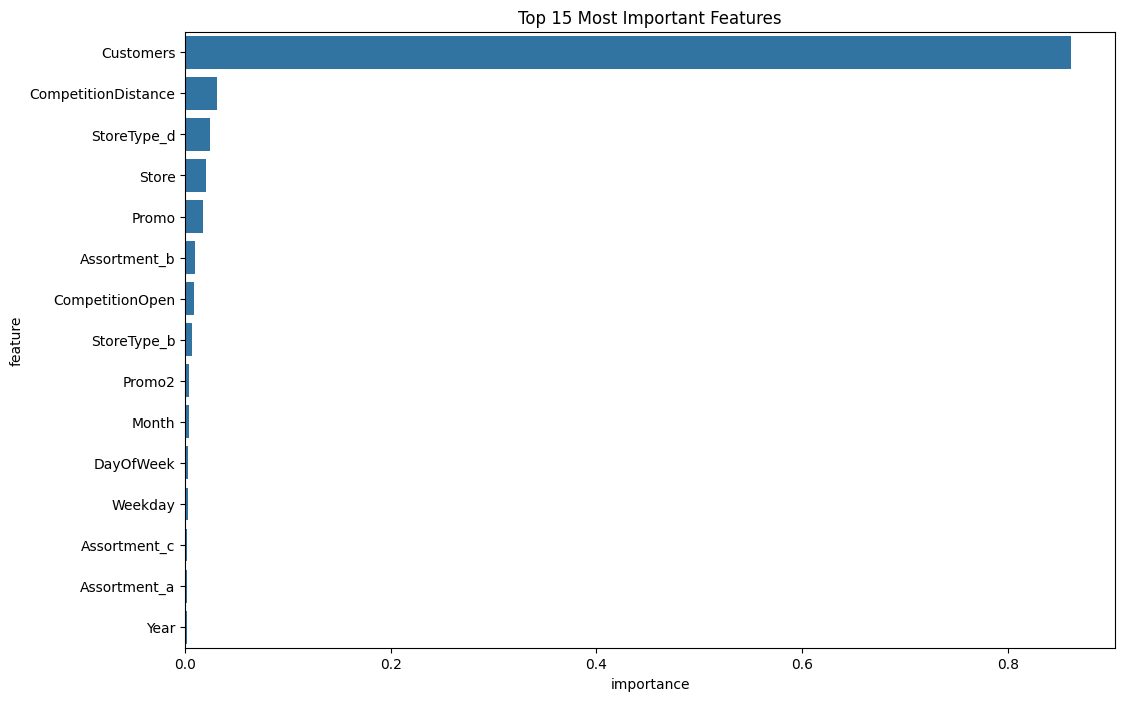

In [28]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features')
plt.show()

### Serialization

In [29]:
import joblib
from datetime import datetime

# Serialize the model
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
joblib.dump(pipeline, f'model_{timestamp}.pkl')

['model_25-09-2024-18-25-55.pkl']

### Random Forest predictions

In [30]:
from scipy import stats

def predict_with_confidence(model, X, confidence=0.95):
    n_iterations = 100
    predictions = np.zeros((n_iterations,) + (X.shape[0],))
    
    for i in range(n_iterations):
        predictions[i,:] = model.predict(X)
    
    y_pred = np.mean(predictions, axis=0)
    y_err = stats.t.ppf((1 + confidence) / 2., n_iterations - 1) * np.std(predictions, axis=0)
    
    return y_pred, y_err

In [ ]:
# Get predictions with confidence intervals
y_pred, y_err = predict_with_confidence(pipeline, X_test)

NameError: name 'y_err' is not defined

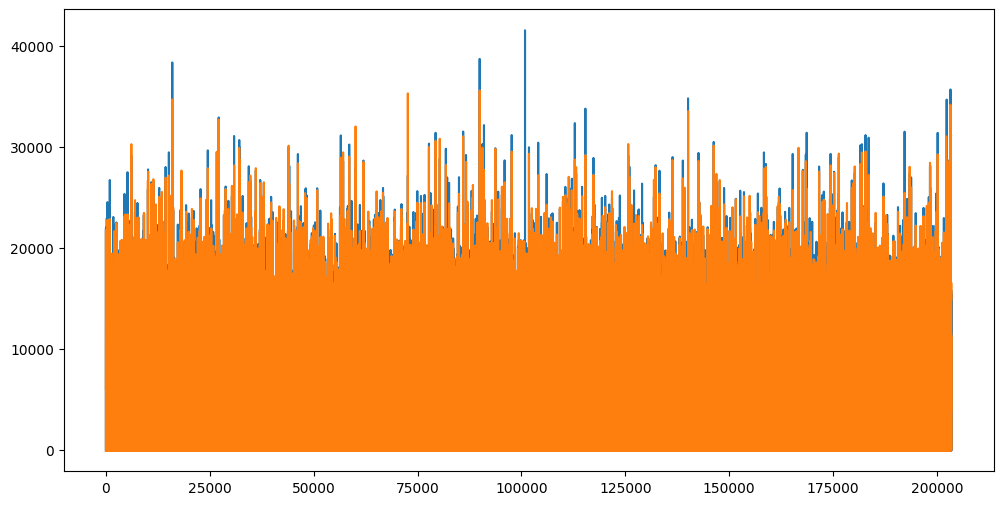

In [33]:
# Plot predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.fill_between(range(len(y_pred)), y_pred - y_err, y_pred + y_err, alpha=0.2)
plt.title('Random Forest: Predicted vs Actual Sales with Confidence Intervals')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Load the test data
test = pd.read_csv('../data/test.csv')

# Merge test and store data
test_df = pd.merge(test, store, on='Store', how='left')

# Apply the same preprocessing steps to test_df as we did to the training data
# (You'll need to repeat the preprocessing steps from Step 2 here)

# Prepare the features for prediction
X_test_final = test_df[features]

# Make predictions
test_predictions = pipeline.predict(X_test_final)

# Prepare submission
submission = pd.DataFrame({
    'Id': test['Id'],
    'Sales': test_predictions
})
submission.to_csv('submission.csv', index=False)

In [ ]:
# Prepare submission
submission = pd.DataFrame({
    'Id': test['Id'],
    'Sales': test_predictions
})
submission.to_csv('submission.csv', index=False)